In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [4]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

from IPython.display import display, Markdown

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u

from scipy import stats, integrate
from scipy.stats import binom
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve
import tensorflow as tf

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [5]:
os.chdir('/home/walml/repos/zoobot')

In [6]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [8]:
predictions_loc = 'results/temp/decals_n2_allq_m0_all.csv'
predictions = pd.read_csv(predictions_loc)
# filter to eval
eval_loc = 'results/temp/decals_n2_allq_m0_eval_shards/eval_df.csv'
eval_df = pd.read_csv(eval_loc)
eval_predictions = predictions[predictions['iauname'].isin(eval_df['id_str'])]
print(len(eval_predictions))
samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
samples_list = [samples]

catalog = eval_predictions
catalog['local_png_loc'] = catalog['local_png_loc'].apply(lambda x: x.replace('/data/phys-zooniverse/chri5177', '/media/walml/beta/decals'))

10000


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [9]:
is_retired = eval_predictions['smooth-or-featured_total-votes'] > 36 
retired = eval_predictions[is_retired]
retired_samples = samples[is_retired]

In [10]:
len(retired)

2765

In [12]:
predicted_fractions = dirichlet_stats.dirichlet_prob_of_answers(retired_samples, schema)

In [13]:
predicted_fractions

array([[0.14736278, 0.7837869 , 0.06885032, ..., 0.1582532 , 0.06368818,
        0.01177202],
       [0.6597639 , 0.23996136, 0.10027474, ..., 0.20113917, 0.05359779,
        0.0093448 ],
       [0.45793256, 0.3235795 , 0.21848793, ..., 0.24423535, 0.10315116,
        0.18219051],
       ...,
       [0.29490203, 0.5857606 , 0.1193374 , ..., 0.28990406, 0.32984072,
        0.10711332],
       [0.23836474, 0.5105999 , 0.2510353 , ..., 0.10111461, 0.04254027,
        0.07221568],
       [0.1483221 , 0.70729196, 0.14438596, ..., 0.24339052, 0.20356973,
        0.22812709]], dtype=float32)

In [14]:
# answer = 'smooth-or-featured_smooth'
# answer = schema.get_answer('smooth-or-featured_featured-or-disk')
# answer = schema.get_answer('smooth-or-featured_artifact')
# answer = schema.get_answer('bar_weak')
question = schema.get_question('smooth-or-featured')

In [15]:
len(schema.questions)

10

In [16]:
def get_label(text, question):
    return clean_text(text.replace(question.text, '').title())

In [17]:
def clean_text(text):
    return text.replace('-', ' ').replace('_', '').title()

In [18]:
question

smooth-or-featured, indices 0 to 2, asked after None

In [19]:
from zoobot.active_learning import acquisition_utils

In [20]:
retirement = 1
samples = np.expand_dims(predicted_fractions, axis=-1)
# acquisition_utils.get_expected_votes(samples, question, retirement, schema, round_votes=False).shape

# Discrete Metrics

In [184]:
def filter_to_sensible(label_df, predictions, question):
#     if prev_a is not None:
#         prev_q = prev_a.question
#         prev_q_cols = [answer.text + '_fraction' for answer in prev_q.answers]
#         is_sensible = (label_df[prev_a.text + '_fraction'] / label_df[prev_q_cols].sum(axis=1)) > 0.5
#         valid_labels, valid_predictions = label_df[is_sensible], predicted_fractions[is_sensible]
#     else:
#         valid_labels, valid_predictions = label_df, predicted_fractions
    retirement = 1
    samples = np.expand_dims(predictions, axis=-1)
    expected_votes = acquisition_utils.get_expected_votes_human(label_df, question, retirement, schema, round_votes=False)
    if not isinstance(expected_votes, np.ndarray):
        expected_votes = expected_votes.numpy()  # hack, should fix properly...
#     print(expected_votes)
    is_sensible = expected_votes > 0.5
    valid_labels, valid_predictions = label_df[is_sensible], predictions[is_sensible]
    return valid_labels, valid_predictions

In [22]:
len(retired)

2765

In [23]:
np.sum((retired['smooth-or-featured_featured-or-disk_fraction'] * retired['disk-edge-on_no_fraction']) > 0.5)

688

In [24]:
valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, schema.get_question('has-spiral-arms'))
len(valid_labels)

[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]


688

In [25]:
expected_votes = acquisition_utils.get_expected_votes_human(retired, question, retirement, schema, round_votes=False)

In [26]:
def show_confusion_matrix(question, label_df, predicted_fractions):
    
    # previous question should be valid
    valid_labels, valid_predictions = filter_to_sensible(label_df, predicted_fractions, question)

    
    cols = [answer.text + '_fraction' for answer in question.answers]
    y_true = np.argmax(valid_labels[cols].values, axis=1)

    y_pred = np.argmax(valid_predictions[:, question.start_index:question.end_index+1], axis=1)


    cm = confusion_matrix(y_true, y_pred)

    labels = [get_label(a.text, question) for a in question.answers]
    
    fig, ax = plt.subplots()
    ax.set_title(clean_text(question.text))

    return sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='d',
        xticklabels=labels,
        yticklabels=labels,
        cbar=False,
        annot_kws={"size": 14},
        ax=ax,
        square=True,
        robust=True
    )


[1. 1. 1. ... 1. 1. 1.]


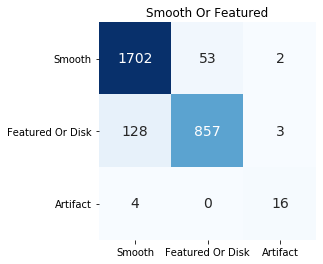

In [27]:
show_confusion_matrix(question, retired, predicted_fractions)

In [28]:
# high_confidence = (retired[answer.text + '_fraction'] > 0.8) | (retired[answer.text + '_fraction'] < 0.2)

# show_confusion_matrix(question, retired[high_confidence], predicted_fractions[high_confidence])

[1. 1. 1. ... 1. 1. 1.]
[0.87804878 0.29545455 0.36363636 ... 0.51219512 0.68292683 0.80952381]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.04878049 0.56818182 0.38636364 ... 0.36585366 0.2195122  0.12698413]
[0.12195122 0.02272727 0.         ... 0.07317073 0.6097561  0.03174603]
[0.70731707 0.11363636 0.         ... 0.07317073 0.04878049 0.57142857]
[0.70731707 0.11363636 0.         ... 0.07317073 0.04878049 0.57142857]
[1. 1. 1. ... 1. 1. 1.]


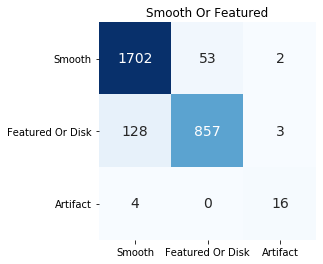

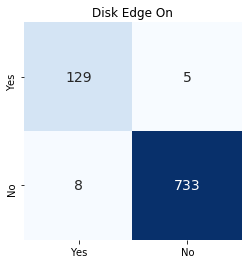

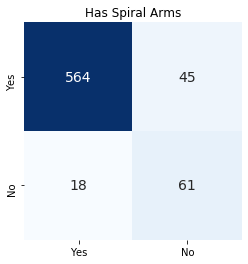

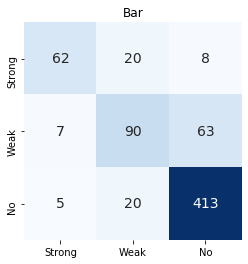

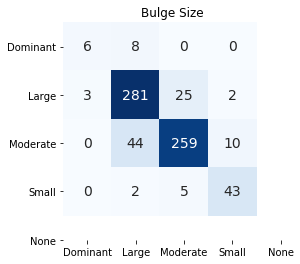

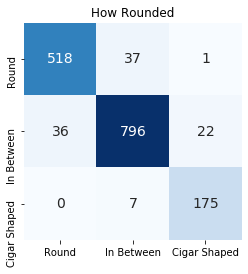

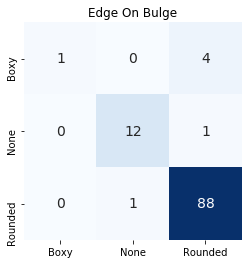

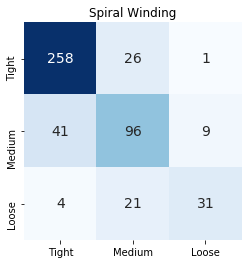

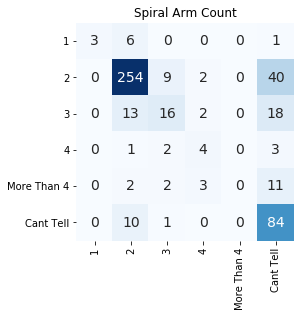

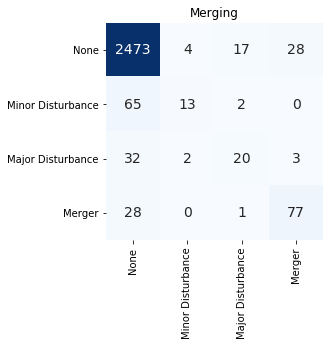

In [29]:
for question in schema.questions:
    fig = show_confusion_matrix(question, retired, predicted_fractions)
#     plt.savefig('/home/walml/repos/zoobot/results/temp/mean_cm_decals_n2_m0_allq_' + question.text + '.png')

# Regression Metrics

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
errors = []
for question_n, question in enumerate(schema.questions):
    for answer in question.answers:
        valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
        absolute = mean_absolute_error(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index])
        mse = mean_squared_error(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index])
        errors.append({'answer': answer.text, 'rmse': np.sqrt(mse), 'mean_absolute_error': absolute, 'question_n': question_n})

metrics = pd.DataFrame(errors)


[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[0.87804878 0.29545455 0.36363636 ... 0.51219512 0.68292683 0.80952381]
[0.87804878 0.29545455 0.36363636 ... 0.51219512 0.68292683 0.80952381]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.04878049 0.56818182 0.38636364 ... 0.36585366 0.2195122  0.12

In [32]:
sns.set()

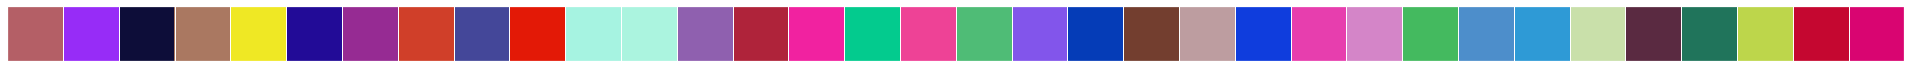

In [33]:
# color = dict(zip([a.text for a in schema.answers], [np.random.rand(4) for n in range(len(schema.answers))]))
random_color_list = [np.random.rand(4) for n in range(len(metrics))]
palette = sns.color_palette(random_color_list)
# palette = sns.color_palette('Blues')
sns.palplot(palette)

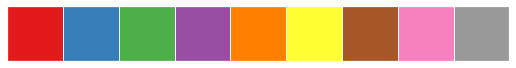

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

In [34]:
sns.choose_colorbrewer_palette('qualitative')

In [35]:
colorbrewer = [
    '#8dd3c7',
    '#ffffb3',
    '#bebada',
    '#fb8072',
    '#80b1d3',
    '#fdb462',
    '#b3de69',
    '#fccde5',
    '#d9d9d9',
    '#bc80bd'
]
base_palette = sns.color_palette(colorbrewer)


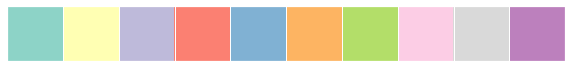

In [36]:
# base_palette = sns.husl_palette(len(schema.questions))
# base_palette = sns.choose_colorbrewer_palette('qualitative')

# import random
# random.shuffle(base_palette)
sns.palplot(base_palette)

In [37]:
repeating_palette = []
for q_n, question in enumerate(schema.questions):
    for a_n, answer in enumerate(question.answers):
        repeating_palette.append(base_palette[q_n])

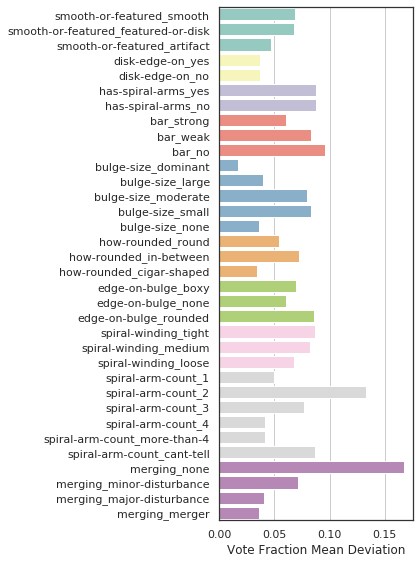

In [38]:
sns.set_style('whitegrid', {'axes.edgecolor': '0.2'})
sns.set_context('notebook')
sns.set_palette(repeating_palette)
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(data=metrics, y='answer', x='mean_absolute_error', ax=ax)
plt.xlabel('Vote Fraction Mean Deviation')
plt.ylabel('')
fig.tight_layout()
# plt.savefig('mean_deviation_bar.pdf')

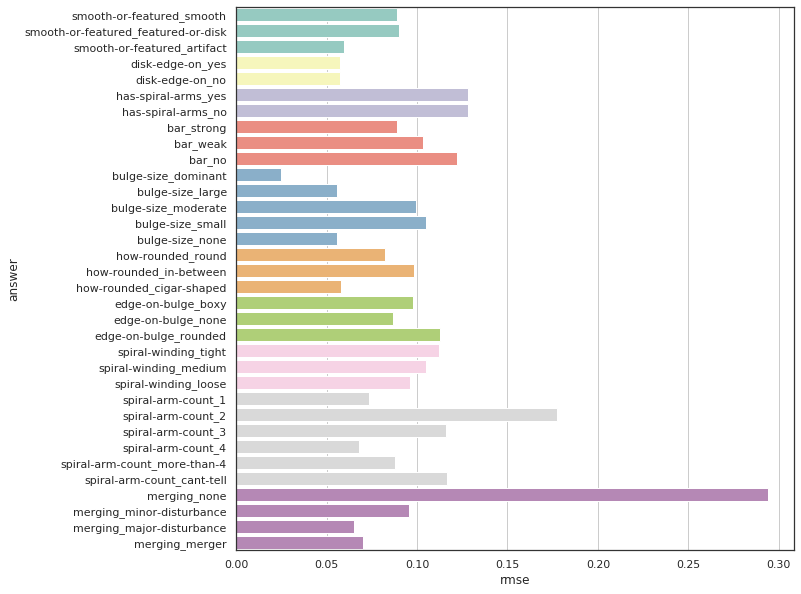

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=metrics, y='answer', x='rmse', ax=ax)

[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]


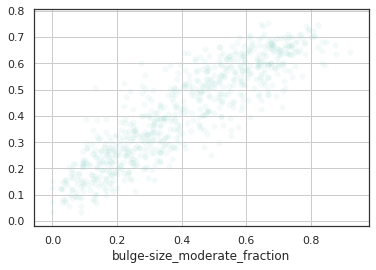

In [40]:

# question = schema.get_question('has-spiral-arms')
answer = schema.get_answer('bulge-size_moderate')
question = answer.question
# answer = question.answers[0]
valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
sns.scatterplot(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index], alpha=.1)



(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         3., 54., 32., 64., 31., 44., 36., 66., 40., 67., 28., 73., 26.,
        20.,  2.,  6.,  3.,  7.,  0.,  7.,  2.,  6.,  2.,  3.,  0.,  2.,
         5.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ,
        16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5,
        33. , 34.5, 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. ,
        49.5, 51. , 52.5, 54. , 55.5, 57. , 58.5, 60. ]),
 <a list of 40 Patch objects>)

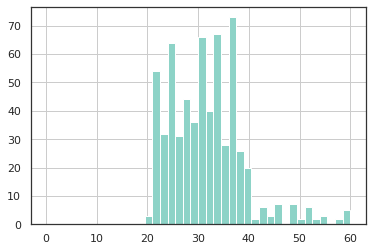

In [41]:
plt.hist(valid_labels[question.text + '_total-votes'], bins=40, range=(0, 60))

In [42]:
question.asked_after

disk-edge-on_no, index 4

In [43]:
valid_labels.iloc[np.argsort(valid_labels[question.text + '_total-votes'])[:10]]['smooth-or-featured_featured-or-disk_fraction']

40842     0.550000
103339    0.550000
33720     0.550000
19559     0.512195
12647     0.525000
48106     0.550000
86855     0.575000
11587     0.675000
62840     0.650000
10911     0.525000
Name: smooth-or-featured_featured-or-disk_fraction, dtype: float64

(array([ 4., 12., 14., 14., 20., 23., 20., 31., 21., 25., 28., 18., 25.,
        26., 26., 17., 26., 17., 13., 18., 29., 16., 26., 20., 16., 29.,
        15., 23., 26., 19., 18., 16., 12.,  8.,  5.,  4.,  5.,  1.,  1.,
         1.]),
 array([0.        , 0.02307692, 0.04615385, 0.06923077, 0.09230769,
        0.11538462, 0.13846154, 0.16153846, 0.18461538, 0.20769231,
        0.23076923, 0.25384615, 0.27692308, 0.3       , 0.32307692,
        0.34615385, 0.36923077, 0.39230769, 0.41538462, 0.43846154,
        0.46153846, 0.48461538, 0.50769231, 0.53076923, 0.55384615,
        0.57692308, 0.6       , 0.62307692, 0.64615385, 0.66923077,
        0.69230769, 0.71538462, 0.73846154, 0.76153846, 0.78461538,
        0.80769231, 0.83076923, 0.85384615, 0.87692308, 0.9       ,
        0.92307692]),
 <a list of 40 Patch objects>)

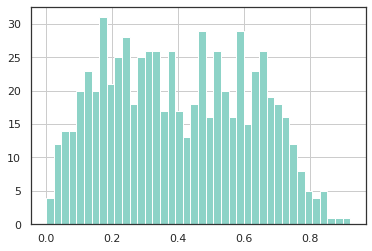

In [44]:
plt.hist(valid_labels[answer.text + '_fraction'], bins=40)

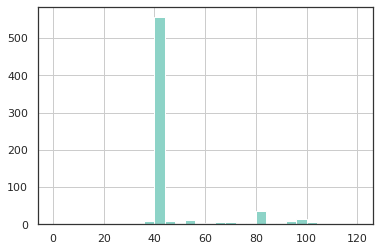

In [45]:
valid_labels['smooth-or-featured_total-votes'].hist(bins=30, range=[0., 120])

[1. 1. 1. ... 1. 1. 1.]
[0.87804878 0.29545455 0.36363636 ... 0.51219512 0.68292683 0.80952381]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.75609756 0.27272727 0.36363636 ... 0.43902439 0.07317073 0.77777778]
[0.04878049 0.56818182 0.38636364 ... 0.36585366 0.2195122  0.12698413]
[0.12195122 0.02272727 0.         ... 0.07317073 0.6097561  0.03174603]
[0.70731707 0.11363636 0.         ... 0.07317073 0.04878049 0.57142857]
[0.70731707 0.11363636 0.         ... 0.07317073 0.04878049 0.57142857]
[1. 1. 1. ... 1. 1. 1.]


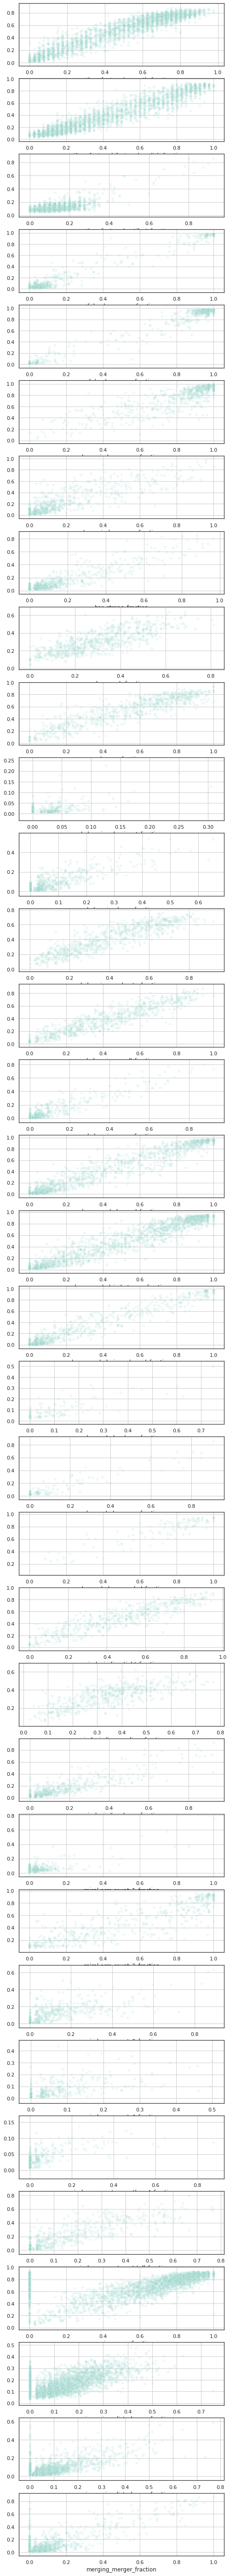

In [46]:

fig, axes = plt.subplots(nrows=len(label_cols), figsize=(8, len(label_cols) * 3))
ax_n = 0
for question in schema.questions:
    valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
    for answer in question.answers:
        sns.scatterplot(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index], ax=axes[ax_n], alpha=.14)
        ax_n += 1


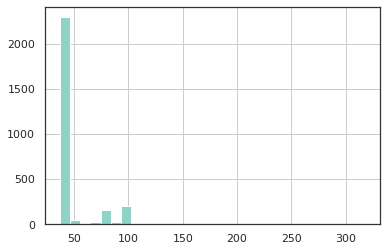

In [47]:
retired['smooth-or-featured_total-votes'].hist(bins=30)

In [48]:
is_intense = retired['smooth-or-featured_total-votes'] > 75
intense_labels, intense_predictions = retired[is_intense], predicted_fractions[is_intense]

In [49]:
def mimic_fewer(galaxy, question):
    data = []
    n_answers = len(question.answers)
    actual_votes = galaxy[[a.text for a in question.answers]].values
    actual_fractions = actual_votes / actual_votes.sum()
    total_votes = actual_votes.sum()
    
    removed_votes = 0
    latest_votes = actual_votes.copy()
    while removed_votes < total_votes:
        fractions = np.array([latest_votes[answer_n]/latest_votes.sum() for answer_n in range(n_answers)])
        assert latest_votes.sum() + removed_votes == total_votes
        data.append({'n_votes': total_votes - removed_votes, 'votes': latest_votes.copy(), 'fractions': fractions, 'deviations': np.abs(fractions - actual_fractions)})
        
#         answer_above_0 = latest_votes > 0
#         valid_answer_indices = np.arange(n_answers)[answer_above_0]
#         index_to_reduce = np.random.choice(valid_answer_indices)
        index_to_reduce = np.random.choice(np.arange(n_answers), p=fractions)
        latest_votes[index_to_reduce] = latest_votes[index_to_reduce] - 1
        removed_votes += 1
        
    return data
            

bar_strong
bar_weak
bar_no


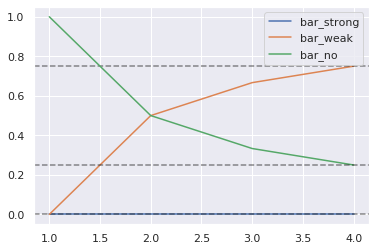

In [225]:
# question = schema.get_question('smooth-or-featured')
# question = schema.get_question('has-spiral-arms')
question = schema.get_question('bar')
# question = schema.get_question('bulge-size')
galaxy = intense_labels.sample().squeeze()
mimic = pd.DataFrame(data=mimic_fewer(galaxy, question))

sns.set()
n_votes = mimic['n_votes']
fractions = np.stack(mimic['fractions'], axis=0)
for answer_n, answer in enumerate(question.answers):
    print(answer.text)
    plt.plot(n_votes, fractions[:, answer_n], label=answer.text)
    plt.axhline(mimic.sort_values('n_votes')['fractions'].iloc[-1][answer_n], linestyle='--', color='k', alpha=.5)
plt.legend()

In [226]:
mimic['deviations']

0                                    [0.0, 0.0, 0.0]
1    [0.0, 0.08333333333333337, 0.08333333333333331]
2                                  [0.0, 0.25, 0.25]
3                                  [0.0, 0.75, 0.75]
Name: deviations, dtype: object

bar_strong
bar_weak
bar_no


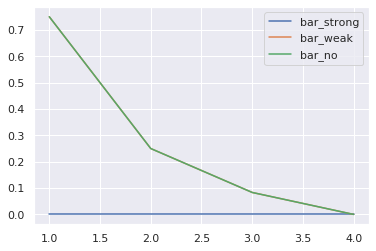

In [227]:
sns.set()
deviations = np.stack(mimic['deviations'], axis=0)
n_votes = mimic['n_votes']
for answer_n, answer in enumerate(question.answers):
    print(answer.text)
    plt.plot(n_votes, deviations[:, answer_n], label=answer.text)
plt.legend()

In [228]:
question

bar, indices 7 to 9, asked after disk-edge-on_no, index 4

In [229]:
data = []
valid_intense, _ = filter_to_sensible(intense_labels, intense_predictions, question)
# print(len(valid_intense))
for n_votes in np.arange(1, 41):
    print(n_votes)
    all_deviations = []
    for _, galaxy in valid_intense.iterrows():
        mimic = pd.DataFrame(data=mimic_fewer(galaxy, question))
        deviations = list(mimic.query(f'n_votes == {n_votes}')['deviations'].squeeze())
        all_deviations.append(deviations)
    all_deviations = np.stack(all_deviations, axis=0)
    mean_abs = all_deviations.mean(axis=0)
    result = {'n_votes': n_votes}
    result.update(dict(zip([a.text for a in question.answers], mean_abs)))
    data.append(result)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [230]:
deviation_df = pd.DataFrame(data=data)

In [231]:
def convert_to_label(x):
    return x.replace(question.text, '').replace('_', '').capitalize()

In [232]:
# colors = sns.color_palette('mako', 5)
# colors = sns.color_palette('mako')
# colors = base_palette

# colorbrewer = [
#     '#8dd3c7',
#     '#ffffb3',
#     '#bebada',
#     '#fb8072',
#     '#80b1d3',
#     '#fdb462',
#     '#b3de69',
#     '#fccde5',
#     '#d9d9d9',
#     '#bc80bd'
# ]
# colors = sns.color_palette(colorbrewer[-5:])


In [233]:
# prob_of_answers = np.expand_dims(galaxy[[a.text + '_fraction' for a in schema.answers]], axis=0)
# galaxy['smooth-or-featured_featured-or-disk_fraction']                         
# deviation_df['n_votes_total'] = deviation_df['n_votes'] / schema.joint_p(prob_of_answers, question.asked_after.text)  # looks more impressive, but is maybe a level of complexity too far - not used

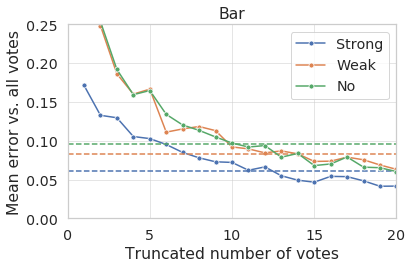

In [236]:
sns.set_context('notebook')
sns.set(font_scale=1.3, style='whitegrid', rc={'grid.linewidth': .5})  # softening the grid lines

colors = sns.color_palette('deep', len(question.answers))
# colors = ['y', 'b', 'g', 'r', 't']

for a_n, a in enumerate(question.answers):
# exclude 'dominant' for bulge, rare
    sns.lineplot(data=deviation_df, x='n_votes', y=a.text, color=colors[a_n], label=convert_to_label(a.text), marker='.', markersize=10.)
    plt.axhline(metrics.query(f'answer == "{a.text}"').squeeze()['mean_absolute_error'], color=colors[a_n], linestyle='--')
plt.legend()
plt.ylabel('Mean error vs. all votes')
plt.xlabel('Truncated number of votes')
# if question.text == 'smooth-or-featured':
plt.xlim([0, 20])
plt.ylim(0., .25)
# if question.text == 'bulge-size':
#     plt.xlim([0, 20])
#     plt.ylim(0., .25)
plt.title(question.text.replace('-', ' ').title())  # .title = capitalize each word (isn't python <3)
plt.tight_layout()
plt.savefig('notebooks/multiq/performance/vs_all_votes_' + question.text + '.png')
plt.savefig('notebooks/multiq/performance/vs_all_votes_' + question.text + '.pdf')

In [235]:
!pwd

/home/walml/repos/zoobot
